In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re

from transformers import BertTokenizer, BertForSequenceClassification, BertModel
# from transformers import BertClassifier
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from tqdm import tqdm
import torch.nn as nn
import warnings
import matplotlib.pyplot as plt

# ignoring all the future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Download NLTK resources
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')


from transformers import BertTokenizerFast
from torch.utils.data import Dataset
import torch

from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset, DataLoader

from transformers import BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_scheduler
from transformers import BertConfig, BertForTokenClassification
from transformers import BertForQuestionAnswering

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Reading the datasets

In [ ]:
df_train = pd.read_csv('/content/propaganda_train.tsv', sep='\t')
df_test = pd.read_csv('/content/propaganda_val.tsv', sep='\t')

In [ ]:
print("Shape of training data:", df_train.shape)
df_train

Shape of training data: (2414, 2)


,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"
...,...,...
2409,not_propaganda,<BOS> We support and appreciate <EOS> your bus...
2410,not_propaganda,International Atomic Energy Agency (IAEA) Dire...
2411,not_propaganda,What has been done: there has been work on for...
2412,not_propaganda,This is <BOS> the law of gradualness not the g...


In [ ]:
print("Shape of testing data:", df_test.shape)
df_test

Shape of testing data: (580, 2)


,label,tagged_in_context
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...
...,...,...
575,not_propaganda,"NewsCatholic Church, <BOS> Family, Marriage <E..."
576,not_propaganda,"Remember our saying, modern day fairy <BOS> ta..."
577,not_propaganda,Why <BOS> not <EOS> open up to Iran with massi...
578,flag_waving,<BOS> He also sang an Islamic State fight song...


#Data exploration

In [ ]:
# Check for nulls
print(df_train.isnull().sum())

label                0
tagged_in_context    0
dtype: int64


In [ ]:
# Check unique labels
print("Unique labels:", df_train['label'].unique())

Unique labels: ['not_propaganda' 'flag_waving' 'loaded_language' 'doubt'
 'name_calling,labeling' 'appeal_to_fear_prejudice' 'repetition'
 'causal_oversimplification' 'exaggeration,minimisation']


In [ ]:
# Preview a random example
sample = df_train.sample(1).iloc[0]
print("\nLabel:", sample['label'])
print("Sentence:", sample['tagged_in_context'])



Label: not_propaganda
Sentence: This <BOS> necessarily meant that Kennedy had been shot from the front, not <EOS> the rear, where accused assassin Lee Harvey Oswald was situated. 


#Exploratory Data Analysis

In [ ]:
print("\nLabel distribution:\n", df_train['label'].value_counts())


Label distribution:
 label
not_propaganda               1191
exaggeration,minimisation     164
causal_oversimplification     158
name_calling,labeling         157
loaded_language               154
appeal_to_fear_prejudice      151
flag_waving                   148
repetition                    147
doubt                         144
Name: count, dtype: int64


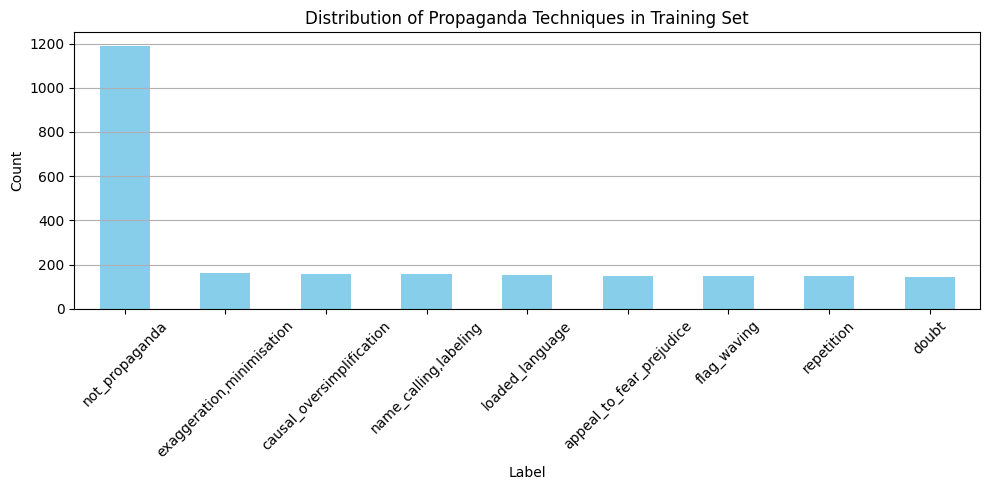

In [ ]:
label_counts = df_train['label'].value_counts()

plt.figure(figsize=(10,5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Propaganda Techniques in Training Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
print("\nLabel distribution:\n", df_test['label'].value_counts())


Label distribution:
 label
not_propaganda               301
appeal_to_fear_prejudice      43
flag_waving                   39
doubt                         38
loaded_language               37
repetition                    32
causal_oversimplification     31
name_calling,labeling         31
exaggeration,minimisation     28
Name: count, dtype: int64


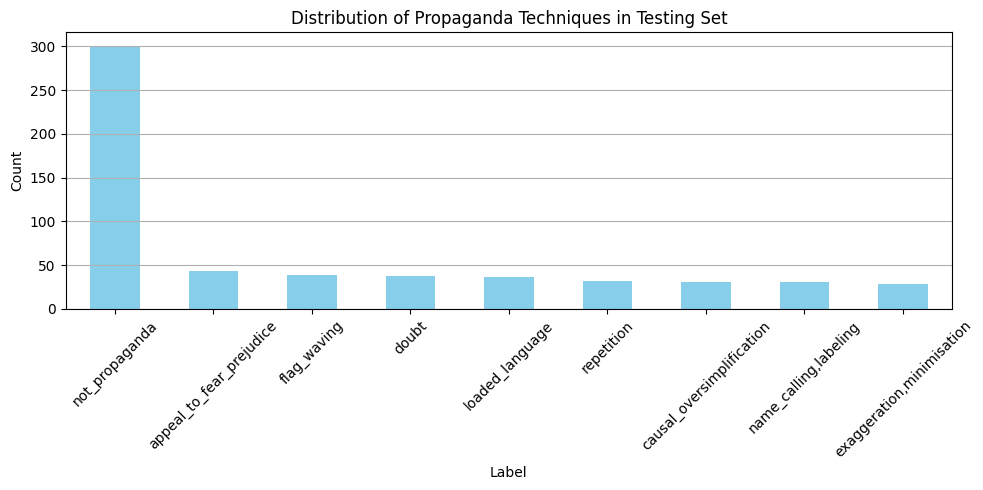

In [ ]:
label_counts = df_test['label'].value_counts()

plt.figure(figsize=(10,5))
label_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Propaganda Techniques in Testing Set")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#Span and Sentence Length Analysis

In [ ]:
def extract_span(sentence):
    match = re.search(r"<BOS>(.*?)<EOS>", sentence)
    return match.group(1).strip() if match else ""

# Add new columns
df_train["span"] = df_train["tagged_in_context"].apply(extract_span)
df_train["span_length"] = df_train["span"].apply(lambda x: len(x.split()))
df_train["sentence_length"] = df_train["tagged_in_context"].apply(lambda x: len(x.split()))

# Stats
print("\nAverage span length:", df_train["span_length"].mean())
print("Max span length:", df_train["span_length"].max())

print("Average sentence length:", df_train["sentence_length"].mean())
print("Max sentence length:", df_train["sentence_length"].max())



Average span length: 8.759320629660316
Max span length: 141
Average sentence length: 29.138359569179784
Max sentence length: 1311


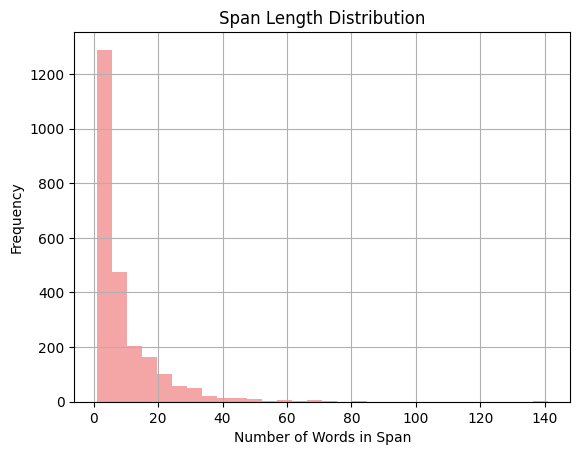

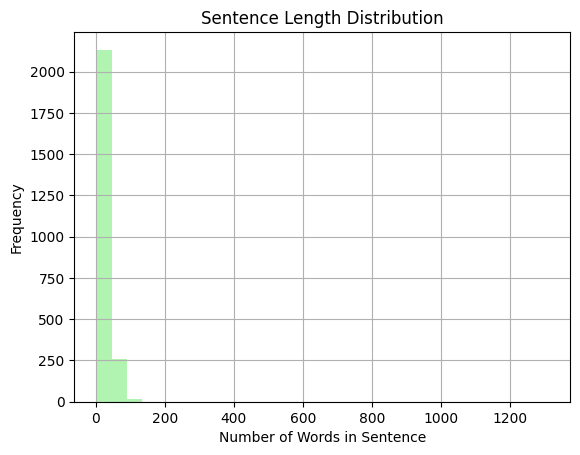

In [ ]:
plt.hist(df_train["span_length"], bins=30, color='lightcoral', alpha=0.7)
plt.title("Span Length Distribution")
plt.xlabel("Number of Words in Span")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

plt.hist(df_train["sentence_length"], bins=30, color='lightgreen', alpha=0.7)
plt.title("Sentence Length Distribution")
plt.xlabel("Number of Words in Sentence")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# Show a few examples for each class
for label in df_train['label'].unique():
    sample = df_train[df_train['label'] == label].iloc[0]
    print(f"\nLabel: {label}")
    print("tagged_in_context:", sample['tagged_in_context'])
    print("Span:", sample['span'])



Label: not_propaganda
tagged_in_context: No, <BOS> he <EOS> will not be confirmed. 
Span: he

Label: flag_waving
tagged_in_context: The Obama administration misled the <BOS> American people <EOS> and Congress because they were desperate to get a deal with Iran, said Sen. 
Span: American people

Label: loaded_language
tagged_in_context: Hitler <BOS> annihilated <EOS> 400,000 Germans who were handicapped or suffered from chronic diseases. 
Span: annihilated

Label: doubt
tagged_in_context: As noted above, at this point literally every piece of <BOS> so-called evidence <EOS> put forth by authorities and then regurgitated by the mainstream media cannot be trusted and should be considered as disinformation until proven otherwise. 
Span: so-called evidence

Label: name_calling,labeling
tagged_in_context: His account was suspended for violating Twitter’s rules relating to “<BOS> hateful conduct <EOS>.” It is "hateful conduct", apparently, to reference what Islamic texts themselves say. 
Span

#Task 1

#Preprocesseing data for Task 1

In [ ]:
def extract_span(text):
    try:
        start = text.index("<BOS>") + 5
        end = text.index("<EOS>")
        return text[start:end].strip()
    except ValueError:
        return None

In [ ]:
def clean_sentence(text):
    return text.replace("<BOS>", "").replace("<EOS>", "").strip()

In [ ]:
df_train['span'] = df_train['tagged_in_context'].apply(extract_span)
df_train['clean_sentence'] = df_train['tagged_in_context'].apply(clean_sentence)

In [ ]:
print(df_train[['label', 'span', 'clean_sentence']].head())

            label                                               span  \
0  not_propaganda                                                 he   
1  not_propaganda  won’t make things any worse than they are for ...   
2     flag_waving                                    American people   
3  not_propaganda                                                and   
4  not_propaganda                        Location: Westerville, Ohio   

                                      clean_sentence  
0                    No,  he  will not be confirmed.  
1  This declassification effort  won’t make thing...  
2  The Obama administration misled the  American ...  
3  “It looks like we’re capturing the demise of t...  
4                        Location: Westerville, Ohio  


In [ ]:
label_counts = df_train['label'].value_counts()

# TF-IDF + Logistic Regression classifier

In [ ]:
# Filter only propaganda examples
df_task1 = df_train[df_train['label'] != 'not_propaganda'].copy()

In [ ]:
print("Before filtering:", df_train.shape)
print("After filtering:", df_task1.shape)
print("Remaining labels:", df_task1['label'].unique())

Before filtering: (2414, 6)
After filtering: (1223, 6)
Remaining labels: ['flag_waving' 'loaded_language' 'doubt' 'name_calling,labeling'
 'appeal_to_fear_prejudice' 'repetition' 'causal_oversimplification'
 'exaggeration,minimisation']


In [ ]:
# Create a new column: "input_text" = span + sentence context
df_task1['input_text'] = df_task1['span'] + " ||| " + df_task1['clean_sentence']

In [ ]:
print(df_task1[['label', 'input_text']].head())

                       label  \
2                flag_waving   
5            loaded_language   
8                      doubt   
10     name_calling,labeling   
12  appeal_to_fear_prejudice   

                                           input_text  
2   American people ||| The Obama administration m...  
5   annihilated ||| Hitler  annihilated  400,000 G...  
8   so-called evidence ||| As noted above, at this...  
10  hateful conduct ||| His account was suspended ...  
12  point to Iran’s positioning itself for more ag...  


In [ ]:
#encode remaining labels
label_encoder = LabelEncoder()
df_task1['label_encoded'] = label_encoder.fit_transform(df_task1['label'])

In [ ]:
#label mapping
label_map = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_map)

Label Mapping: {'appeal_to_fear_prejudice': np.int64(0), 'causal_oversimplification': np.int64(1), 'doubt': np.int64(2), 'exaggeration,minimisation': np.int64(3), 'flag_waving': np.int64(4), 'loaded_language': np.int64(5), 'name_calling,labeling': np.int64(6), 'repetition': np.int64(7)}


In [ ]:
X = df_task1['input_text']
y = df_task1['label_encoded']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=5000)

In [ ]:
# Fit on training data and transform both sets
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [ ]:
# Initialize and train the classifier
clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train_tfidf, y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [ ]:
# Predict on validation set
y_pred = clf.predict(X_val_tfidf)

In [ ]:
# Evaluate
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

Accuracy: 0.3551020408163265

Classification Report:

                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.39      0.43      0.41        30
causal_oversimplification       0.32      0.38      0.34        32
                    doubt       0.52      0.48      0.50        29
exaggeration,minimisation       0.36      0.39      0.38        33
              flag_waving       0.53      0.60      0.56        30
          loaded_language       0.19      0.16      0.17        31
    name_calling,labeling       0.17      0.16      0.16        31
               repetition       0.35      0.24      0.29        29

                 accuracy                           0.36       245
                macro avg       0.35      0.36      0.35       245
             weighted avg       0.35      0.36      0.35       245



In [ ]:
# Print predicted vs actual labels
for text, true_label, pred_label in zip(X_val, y_val, y_pred):
    print(f"TEXT: {text}")
    print(f"TRUE LABEL: {true_label}")
    print(f"PREDICTED LABEL: {pred_label}")
    print("-" * 80)


TEXT: dumbed down ||| Many parents are motivated by a desire to give their children something better than a curriculum that has been  dumbed down  by federal initiatives like Common Core.
TRUE LABEL: 7
PREDICTED LABEL: 7
--------------------------------------------------------------------------------
TEXT: Any Jew who opposes the Occupation — or opposes Zionism itself — knows that feeling of being shunned from the places that are supposed to shelter and nurture you: families, synagogues, community centers, arts organizations, ||| Any Jew who opposes the Occupation — or opposes Zionism itself — knows that feeling of being shunned from the places that are supposed to shelter and nurture you: families, synagogues, community centers, arts organizations,  Fishback continues.
TRUE LABEL: 0
PREDICTED LABEL: 1
--------------------------------------------------------------------------------
TEXT: making the claim that Jews have experienced such abuse because they have somehow been cursed ||| Re

#BERT based classifier

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Create sentence format: [CLS] sentence [SEP] span [SEP]
def combine_for_bert(row):
    return tokenizer(
        row['clean_sentence'],
        row['span'],
        padding='max_length',
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )

In [ ]:
df_task1 = df_train[df_train['label'] != 'not_propaganda'].copy()
df_task1['label_encoded'] = LabelEncoder().fit_transform(df_task1['label'])

# Store input-output pairs
texts = list(zip(df_task1['clean_sentence'], df_task1['span']))
labels = df_task1['label_encoded'].values

In [ ]:
class PropagandaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        sentence, span = self.texts[idx]
        encoding = self.tokenizer(
            sentence,
            span,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item


In [ ]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

train_dataset = PropagandaDataset(train_texts, train_labels, tokenizer)
val_dataset = PropagandaDataset(val_texts, val_labels, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

#Fine Tune BERT

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(labels)))
model.to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                             num_warmup_steps=0,
                             num_training_steps=num_training_steps)

# Training loop
model.train()
for epoch in range(num_epochs):
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        loop.set_description(f"Epoch {epoch}")
        loop.set_postfix(loss=loss.item())


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 0:  31%|███       | 19/62 [00:08<00:13,  3.12it/s, loss=1.98]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 0:  37%|███▋      | 23/62 [00:09<00:12,  3.10it/s, loss=1.9]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first

In [ ]:
model.eval()
preds, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds += torch.argmax(logits, dim=1).cpu().tolist()
        true_labels += batch['labels'].cpu().tolist()

print("Accuracy:", accuracy_score(true_labels, preds))
print("Classification Report:\n")
print(classification_report(true_labels, preds, target_names=LabelEncoder().fit(df_task1['label']).classes_))


Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Accuracy: 0.5061224489795918
Classification Report:

                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.45      0.60      0.51        30
causal_oversimplification       0.42      0.66      0.51        32
                    doubt       0.73      0.38      0.50        29
exaggeration,minimisation       0.60      0.55      0.57        33
              flag_waving       0.67      0.53      0.59        30
          loaded_language       0.28      0.23      0.25        31
    name_calling,labeling       0.65      0.55      0.60        31
               repetition       0.46      0.55      0.50        29

                 accuracy                           0.51       245
                macro avg       0.53      0.51      0.50       245
             weighted avg       0.53      0.51      0.50       245



In [ ]:
# Print predicted vs actual labels
for text, true_label, pred_label in zip(X_val, y_val, y_pred):
    print(f"TEXT: {text}")
    print(f"TRUE LABEL: {true_label}")
    print(f"PREDICTED LABEL: {pred_label}")
    print("-" * 80)


TEXT: dumbed down ||| Many parents are motivated by a desire to give their children something better than a curriculum that has been  dumbed down  by federal initiatives like Common Core.
TRUE LABEL: 7
PREDICTED LABEL: 7
--------------------------------------------------------------------------------
TEXT: Any Jew who opposes the Occupation — or opposes Zionism itself — knows that feeling of being shunned from the places that are supposed to shelter and nurture you: families, synagogues, community centers, arts organizations, ||| Any Jew who opposes the Occupation — or opposes Zionism itself — knows that feeling of being shunned from the places that are supposed to shelter and nurture you: families, synagogues, community centers, arts organizations,  Fishback continues.
TRUE LABEL: 0
PREDICTED LABEL: 1
--------------------------------------------------------------------------------
TEXT: making the claim that Jews have experienced such abuse because they have somehow been cursed ||| Re

#Task 2

#BERT based BIO Tagging

In [ ]:
# Load the BERT tokenizer once globally
tokenizer_bert = BertTokenizer.from_pretrained("bert-base-uncased")

def extract_span(text):
    """Extract the span inside <BOS> and <EOS> tags."""
    match = re.search(r"<BOS>(.*?)<EOS>", text)
    return match.group(1).strip() if match else None

def clean_tags(text):
    """Remove <BOS> and <EOS> tags from text."""
    return re.sub(r"<BOS>|<EOS>", "", text).strip()

def tag_tokens_with_bio(tokens, span_tokens, label):
    """Assign BIO tags to the tokens based on the span tokens."""
    bio_tags = ["O"] * len(tokens)
    for i in range(len(tokens) - len(span_tokens) + 1):
        if tokens[i:i + len(span_tokens)] == span_tokens:
            bio_tags[i] = f"B-{label}"
            for j in range(1, len(span_tokens)):
                bio_tags[i + j] = f"I-{label}"
            break  # Only label the first matched span
    return bio_tags

def generate_bio_samples(df):
    """
    Convert tagged sentences into BIO-tagged token sequences using BERT tokenizer.
    Expects columns: 'tagged_in_context' and 'label'
    """
    dataset = []

    for _, row in df.iterrows():
        raw_text = row["tagged_in_context"]
        label = row["label"]

        span_text = extract_span(raw_text)
        if span_text is None:
            continue  # Skip if no span is found

        sentence = clean_tags(raw_text)
        tokens = tokenizer_bert.tokenize(sentence)
        span_tokens = tokenizer_bert.tokenize(span_text)
        bio_tags = tag_tokens_with_bio(tokens, span_tokens, label)

        dataset.append({
            "tokens": tokens,
            "labels": bio_tags
        })

    return dataset

# Generate datasets
bio_train_set = generate_bio_samples(df_train)
bio_test_set = generate_bio_samples(df_test)


In [ ]:
# Load tokenizer
tokenizer_fast_bert = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Create tag-ID mappings from training data
unique_tags = {tag for sample in bio_train_set for tag in sample["labels"]}
tag_list = sorted(list(unique_tags))
tag2id = {tag: idx for idx, tag in enumerate(tag_list)}
id2tag = {idx: tag for tag, idx in tag2id.items()}


class PropagandaTokenDataset(Dataset):
    """
    Custom Dataset class for token-level propaganda detection using BIO tags.
    Converts pre-tokenized samples into input tensors and aligned label tensors
    compatible with HuggingFace Transformers.
    """

    def __init__(self, samples, tokenizer, max_length=128):
        """
        Args:
            samples (List[Dict]): List of samples with 'tokens' and 'labels' (BIO format).
            tokenizer (PreTrainedTokenizerFast): HuggingFace tokenizer for BERT.
            max_length (int): Maximum sequence length for padding/truncation.
        """
        self.features = []
        self.label_tensors = []

        for sample in samples:
            # Tokenize with alignment to original words
            encoding = tokenizer(
                sample["tokens"],
                is_split_into_words=True,
                padding="max_length",
                truncation=True,
                max_length=max_length
            )

            word_ids = encoding.word_ids()
            label_ids = []

            for word_idx in word_ids:
                if word_idx is None:
                    label_ids.append(-100)  # Ignore [CLS], [SEP], padding
                else:
                    label_ids.append(tag2id[sample["labels"][word_idx]])

            # Store as tensors
            self.features.append({
                "input_ids": torch.tensor(encoding["input_ids"]),
                "attention_mask": torch.tensor(encoding["attention_mask"])
            })
            self.label_tensors.append(torch.tensor(label_ids))

    def __len__(self):
        return len(self.label_tensors)

    def __getitem__(self, idx):
        return {
            "input_ids": self.features[idx]["input_ids"],
            "attention_mask": self.features[idx]["attention_mask"],
            "labels": self.label_tensors[idx]
        }


In [ ]:
# Create dataset objects for training and validation using the custom dataset class
train_data = PropagandaTokenDataset(bio_train_set, tokenizer_fast_bert)
test_data = PropagandaTokenDataset(bio_test_set, tokenizer_fast_bert)

In [ ]:
#Train a BERT model for token classification using BIO-tagged data

# Load the pre-trained BERT model for token classification
model_token_classifier = BertForTokenClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id
)

# Use GPU if available
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_token_classifier.to(compute_device)

# Set up data loaders for training and validation
loader_train = DataLoader(train_data, batch_size=16, shuffle=True)
loader_val = DataLoader(test_data, batch_size=32)

# Define optimizer
optimizer_token_classifier = AdamW(model_token_classifier.parameters(), lr=5e-5)

# Train for a fixed number of epochs
TOTAL_EPOCHS = 3
for epoch in range(TOTAL_EPOCHS):
    print(f"\n--- Epoch {epoch + 1}/{TOTAL_EPOCHS} ---")
    model_token_classifier.train()
    cumulative_loss = 0

    for batch in tqdm(loader_train):
        optimizer_token_classifier.zero_grad()
        input_ids = batch['input_ids'].to(compute_device)
        attention_mask = batch['attention_mask'].to(compute_device)
        labels = batch['labels'].to(compute_device)

        outputs = model_token_classifier(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer_token_classifier.step()
        cumulative_loss += loss.item()

    mean_loss = cumulative_loss / len(loader_train)
    print(f"Average training loss: {mean_loss:.4f}")

# Evaluation
model_token_classifier.eval()
pred_labels = []
true_labels = []

with torch.no_grad():
    for batch in loader_val:
        input_ids = batch['input_ids'].to(compute_device)
        attention_mask = batch['attention_mask'].to(compute_device)
        labels = batch['labels'].to(compute_device)

        outputs = model_token_classifier(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Collect non-padding predictions and true labels
        for pred_seq, label_seq in zip(predictions, labels):
            for pred_token, true_token in zip(pred_seq.cpu().numpy(), label_seq.cpu().numpy()):
                if true_token != -100:
                    pred_labels.append(pred_token)
                    true_labels.append(true_token)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Epoch 1/3 ---


100%|██████████| 151/151 [00:48<00:00,  3.13it/s]


Average training loss: 1.4078

--- Epoch 2/3 ---


100%|██████████| 151/151 [00:49<00:00,  3.04it/s]


Average training loss: 1.2353

--- Epoch 3/3 ---


100%|██████████| 151/151 [00:49<00:00,  3.04it/s]


Average training loss: 0.9687


In [ ]:
def flatten_bio_tags(label_id):
    return [
        id2tag[label].replace('B-', '').replace('I-', '') if id2tag[label] != 'O' else 'O'
        for label in label_id
    ]

# Apply simplification to predictions and true labels
pred_labels_flat = flatten_bio_tags(pred_labels)
true_labels_flat = flatten_bio_tags(true_labels)

In [ ]:
# Extract all unique label classes from both predictions and ground truth
label_class = sorted(set(true_labels_flat + pred_labels_flat))

# Print evaluation metrics for each propaganda technique
print(classification_report(true_labels_flat, pred_labels_flat, labels=label_class, zero_division=0))

                           precision    recall  f1-score   support

                        O       0.69      0.89      0.78     13541
 appeal_to_fear_prejudice       0.24      0.43      0.31      1031
causal_oversimplification       0.26      0.19      0.22       930
                    doubt       0.36      0.18      0.24      1089
exaggeration,minimisation       0.54      0.09      0.16       292
              flag_waving       0.39      0.17      0.24       585
          loaded_language       0.00      0.00      0.00       244
    name_calling,labeling       0.00      0.00      0.00       256
           not_propaganda       0.00      0.00      0.00      2622
               repetition       0.00      0.00      0.00       134

                 accuracy                           0.63     20724
                macro avg       0.25      0.20      0.19     20724
             weighted avg       0.51      0.63      0.56     20724



#BERT QA model

In [ ]:
train_df = pd.read_csv('/content/Untitled Folder/propaganda_train.tsv', sep='\t')
test_df = pd.read_csv('/content/Untitled Folder/propaganda_val.tsv', sep='\t')

In [ ]:
# Extracts the text between <BOS> and <EOS> tags
def extract_highlighted_text(sentence):
    match = re.search(r'<BOS>(.*?)<EOS>', sentence)
    return match.group(1).strip() if match else ""

# Removes the <BOS> and <EOS> tags to clean the sentence
def strip_span(sentence):
    return re.sub(r'</?BOS>|</?EOS>', '', sentence).strip()

# Apply extraction and cleaning to the training set
train_df['highlight'] = train_df['tagged_in_context'].apply(extract_highlighted_text)
train_df['context'] = train_df['tagged_in_context'].apply(strip_span)

# Deep copy for reference or further processing
df_train_processed = train_df.copy(deep=True)

# Apply extraction and cleaning to the validation set
test_df['highlight'] = test_df['tagged_in_context'].apply(extract_highlighted_text)
test_df['context'] = test_df['tagged_in_context'].apply(strip_span)

# Deep copy for reference or further processing
df_val_processed = test_df.copy(deep=True)

#Prepare data for BERT QA-style span detection

qa_format_train = []
qa_format_test = []

# Function to find start and end character positions of the span in the context
def locate_span_bounds(text, target):
    start_pos = text.find(target)
    end_pos = start_pos + len(target)
    return start_pos, end_pos

# Build QA-style format for training data
for _, row in df_train_processed.iterrows():
    passage = row["context"]
    answer = row["highlight"]

    if answer in passage:
        start_pos, end_pos = locate_span_bounds(passage, answer)
        qa_format_train.append({
            "context": passage,
            "answer_text": answer,
            "start_char": start_pos,
            "end_char": end_pos
        })

# Build QA-style format for validation data
for _, row in df_val_processed.iterrows():
    passage = row["context"]
    answer = row["highlight"]

    if answer in passage:
        start_pos, end_pos = locate_span_bounds(passage, answer)
        qa_format_test.append({
            "context": passage,
            "answer_text": answer,
            "start_char": start_pos,
            "end_char": end_pos
        })

#Load the tokenizer for BERT QA (supports offset mappings)

tokenizer_qa_bert = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [ ]:
#Define a custom Dataset class for QA-style span detection

class BERTQADataset(Dataset):
    def __init__(self, qa_data, tokenise_data, max_length=128):
        self.encoded_samples = []

        for example in qa_data:
            context_text = example["context"]
            answer_text = example["answer_text"]
            start_char = example["start_char"]
            end_char = example["end_char"]

            # Tokenize context with offset mappings to align answer span
            tokenized_output = tokenise_data(
                context_text,
                truncation=True,
                padding='max_length',
                max_length=max_length,
                return_offsets_mapping=True,
                return_tensors='pt'
            )

            # Map character-level span to token-level span
            offset_map = tokenized_output['offset_mapping'][0]
            start_token_idx, end_token_idx = None, None

            for idx, (start, end) in enumerate(offset_map):
                if start <= start_char < end:
                    start_token_idx = idx
                if start < end_char <= end:
                    end_token_idx = idx
                    break

            # Fallback to [CLS] position if span not matched
            if start_token_idx is None:
                start_token_idx = 0
            if end_token_idx is None:
                end_token_idx = 0

            # Clean up the offset mapping
            tokenized_output.pop("offset_mapping")

            # Attach start and end token indices as labels
            tokenized_output["start_positions"] = torch.tensor(start_token_idx)
            tokenized_output["end_positions"] = torch.tensor(end_token_idx)

            self.encoded_samples.append(tokenized_output)

    def __len__(self):
        return len(self.encoded_samples)

    def __getitem__(self, index):
        return {key: val.squeeze() for key, val in self.encoded_samples[index].items()}

In [ ]:
qa_dataset_train = BERTQADataset(qa_format_train, tokenizer_qa_bert)
qa_dataset_val = BERTQADataset(qa_format_test, tokenizer_qa_bert)

In [ ]:
# Initialize BERT for question answering
model_qa_span = BertForQuestionAnswering.from_pretrained("bert-base-uncased")

# Move model to GPU if available
qa_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_qa_span.to(qa_device)

# Set up optimizer
optimizer_qa_span = AdamW(model_qa_span.parameters(), lr=3e-5)

# Create data loaders for training and validation
loader_qa_train = DataLoader(qa_dataset_train, batch_size=16, shuffle=True)
loader_qa_val = DataLoader(qa_dataset_val, batch_size=32)

# Training loop
NUM_EPOCHS = 5
model_qa_span.train()

for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    progress_bar = tqdm(loader_qa_train, desc=f"Epoch {epoch + 1}")

    for batch in progress_bar:
        input_ids = batch['input_ids'].to(qa_device)
        attention_mask = batch['attention_mask'].to(qa_device)
        start_positions = batch['start_positions'].to(qa_device)
        end_positions = batch['end_positions'].to(qa_device)

        optimizer_qa_span.zero_grad()

        outputs = model_qa_span(
            input_ids=input_ids,
            attention_mask=attention_mask,
            start_positions=start_positions,
            end_positions=end_positions
        )

        loss = outputs.loss
        loss.backward()
        optimizer_qa_span.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_epoch_loss = epoch_loss / len(loader_qa_train)
    print(f"Epoch {epoch + 1} - Average Loss: {avg_epoch_loss:.4f}")

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 151/151 [00:52<00:00,  2.90it/s, loss=3.03]


Epoch 1 - Average Loss: 3.1029


Epoch 2: 100%|██████████| 151/151 [00:51<00:00,  2.95it/s, loss=2.1]


Epoch 2 - Average Loss: 2.4656


Epoch 3: 100%|██████████| 151/151 [00:51<00:00,  2.93it/s, loss=2.23]


Epoch 3 - Average Loss: 1.8208


Epoch 4: 100%|██████████| 151/151 [00:51<00:00,  2.94it/s, loss=0.98]


Epoch 4 - Average Loss: 1.0214


Epoch 5: 100%|██████████| 151/151 [00:51<00:00,  2.94it/s, loss=0.87]

Epoch 5 - Average Loss: 0.5014


In [ ]:
# Switch model to evaluation mode
model_qa_span.eval()

# Collect predicted vs true span results
qa_eval_results = []

for idx, row in df_val_processed.iterrows():
    passage_text = row["context"]
    gold_span = row["highlight"]

    # Tokenize with offset mappings to trace back char positions
    tokenized = tokenizer_qa_bert(
        passage_text,
        return_tensors="pt",
        return_offsets_mapping=True,
        truncation=True,
        padding="max_length",
        max_length=128
    )

    input_ids = tokenized["input_ids"].to(qa_device)
    attention_mask = tokenized["attention_mask"].to(qa_device)
    offset_map = tokenized["offset_mapping"][0].tolist()

    with torch.no_grad():
        output = model_qa_span(input_ids=input_ids, attention_mask=attention_mask)
        start_logits = output.start_logits
        end_logits = output.end_logits

        # Identify predicted start and end token indices
        pred_start = torch.argmax(start_logits)
        pred_end = torch.argmax(end_logits)

    # Convert token indices back to character positions and extract predicted span
    if pred_start <= pred_end and pred_end < len(offset_map):
        start_char = offset_map[pred_start][0]
        end_char = offset_map[pred_end][1]
        predicted_span = passage_text[start_char:end_char].strip()
    else:
        predicted_span = ""

    is_correct = predicted_span.lower() == gold_span.lower()

    qa_eval_results.append({
        "Sentence": passage_text,
        "True Span": gold_span,
        "Predicted Span": predicted_span,
        "Match": is_correct
    })

# Compile results into a DataFrame
df_span_eval = pd.DataFrame(qa_eval_results)

# Calculate and display exact match accuracy
span_accuracy = df_span_eval["Match"].mean()
print(f"Span Prediction Accuracy (exact match): {span_accuracy:.2%}")

Span Prediction Accuracy (exact match): 6.72%


In [ ]:
def compute_jaccard(str1, str2):
    tokens_a = set(str1.lower().split())
    tokens_b = set(str2.lower().split())
    if not tokens_a or not tokens_b:
        return 0.0
    return len(tokens_a & tokens_b) / len(tokens_a | tokens_b)

# Updated validation loop to record Jaccard scores
qa_span_comparisons = []

for idx, row in df_val_processed.iterrows():
    passage = row["context"]
    true_answer = row["highlight"]

    # Tokenize with offset mapping for span reconstruction
    tokenized = tokenizer_qa_bert(
        passage,
        return_tensors="pt",
        return_offsets_mapping=True,
        truncation=True,
        padding="max_length",
        max_length=128
    )

    input_ids = tokenized["input_ids"].to(qa_device)
    attention_mask = tokenized["attention_mask"].to(qa_device)
    offset_map = tokenized["offset_mapping"][0].tolist()

    with torch.no_grad():
        output = model_qa_span(input_ids=input_ids, attention_mask=attention_mask)
        start_logits = output.start_logits
        end_logits = output.end_logits

        start_pred = torch.argmax(start_logits)
        end_pred = torch.argmax(end_logits)

    # Extract span if indices are valid
    if start_pred <= end_pred and end_pred < len(offset_map):
        start_char = offset_map[start_pred][0]
        end_char = offset_map[end_pred][1]
        predicted_answer = passage[start_char:end_char].strip()
    else:
        predicted_answer = ""

    # Calculate Jaccard similarity
    jaccard_score = compute_jaccard(predicted_answer, true_answer)
    partial_match = jaccard_score > 0.3

    qa_span_comparisons.append({
        "Sentence": passage,
        "True Span": true_answer,
        "Predicted Span": predicted_answer,
        "Jaccard Overlap": round(jaccard_score, 2),
        "Span Match": partial_match
    })

In [ ]:
df_qa_comparison = pd.DataFrame(qa_span_comparisons)

# Compute average span match score based on Jaccard threshold
partial_match_accuracy = df_qa_comparison["Span Match"].mean()

In [ ]:
model_seq_classifier = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2  # Adjust this if you have more than 2 classes
)

# Move model to GPU if available
model_seq_classifier.to(qa_device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
technique_classes = [
    "loaded_language", "flag_waving", "appeal_to_fear_prejudice",
    "name_calling,labeling", "doubt", "repetition",
    "exaggeration,minimisation", "causal_oversimplification"
]

technique_label_encoder = LabelEncoder()
technique_label_encoder.fit(technique_classes)


model_seq_classifier.eval()
seq_device = next(model_seq_classifier.parameters()).device

predicted_techniques = []

for idx, row in df_qa_comparison.iterrows():
    full_text = row["Sentence"]
    predicted_span = row["Predicted Span"]

    # Combine predicted span with context (similar to Task 1 format)
    input_text = predicted_span + " " + full_text

    # Tokenize and send to model
    tokenized_input = tokenizer_qa_bert(
        input_text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=128
    ).to(seq_device)

    with torch.no_grad():
        output = model_seq_classifier(**tokenized_input)
        pred_label_id = torch.argmax(output.logits, dim=1).item()
        predicted_class = technique_label_encoder.inverse_transform([pred_label_id])[0]

    predicted_techniques.append(predicted_class)


df_qa_comparison["Predicted Technique"] = predicted_techniques
df_qa_comparison["True Technique"] = df_val_processed["label"]
df_qa_comparison["Technique Match"] = df_qa_comparison["Predicted Technique"] == df_qa_comparison["True Technique"]
df_qa_comparison["Full Match"] = df_qa_comparison["Span Match"] & df_qa_comparison["Technique Match"]


span_match_score = df_qa_comparison["Span Match"].mean()
technique_match_score = df_qa_comparison["Technique Match"].mean()
full_match_score = df_qa_comparison["Full Match"].mean()

print(f"Span Match Accuracy:     {span_match_score:.2%}")
print(f"Technique Accuracy:      {technique_match_score:.2%}")
print(f"Full Match Accuracy:     {full_match_score:.2%}")


df_correct_nonneutral = df_qa_comparison[
    (df_qa_comparison["Full Match"] == True) &
    (df_qa_comparison["True Technique"] != "not_propaganda")
]

# Display top examples
display(df_correct_nonneutral.head(10))

Span Match Accuracy:     44.14%
Technique Accuracy:      6.55%
Full Match Accuracy:     4.83%


,Sentence,True Span,Predicted Span,Jaccard Overlap,Span Match,Predicted Technique,True Technique,Technique Match,Full Match
20,The local tradition is said to be one of the m...,The local tradition is said to be one of the m...,causes of the spread of this disease .,0.40,True,causal_oversimplification,causal_oversimplification,True,True
55,We have no choice but to clean up our governme...,We have no choice but to clean up our governme...,to clean up our government because the rest of...,0.74,True,appeal_to_fear_prejudice,appeal_to_fear_prejudice,True,True
92,He praised the rapid response from WHO and Mad...,but warned that the danger was not over,rapid response from WHO and Madagascar authori...,0.40,True,appeal_to_fear_prejudice,appeal_to_fear_prejudice,True,True
95,The enemy is not only at the gates but has now...,The enemy is not only at the gates but has now...,The enemy is not only at the gates but has now...,1.00,True,appeal_to_fear_prejudice,appeal_to_fear_prejudice,True,True
99,Should the disease actually spread to the Afri...,making a global pandemic much more likely,making a global pandemic much more likely,1.00,True,appeal_to_fear_prejudice,appeal_to_fear_prejudice,True,True
133,That is a danger .,That is a danger,That is a danger,1.00,True,appeal_to_fear_prejudice,appeal_to_fear_prejudice,True,True
157,Or do we leave our forces in Syria and Iraq an...,Or do we leave our forces in Syria and Iraq an...,do we leave our forces in Syria and Iraq and d...,0.74,True,appeal_to_fear_prejudice,appeal_to_fear_prejudice,True,True
174,"Think of this, the meekest man alive was sent ...",to tell him to obey or else,the meekest man alive was sent to the face of ...,0.40,True,appeal_to_fear_prejudice,appeal_to_fear_prejudice,True,True
182,“ Al Franken must be held accountable if our p...,Al Franken must be held accountable if our par...,Al Franken must be held accountable if our par...,0.89,True,appeal_to_fear_prejudice,appeal_to_fear_prejudice,True,True
198,Suffering the penalty not only allows the crim...,Suffering the penalty not only allows the crim...,Suffering the penalty not only allows the crim...,1.00,True,causal_oversimplification,causal_oversimplification,True,True


# Ruled based classifier

In [ ]:
# Ensure stopwords are downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# --- Define keyword-based rule patterns for each propaganda technique ---
rule_patterns = {
    "flag waving": [
        r"\bour troops\b", r"\bour soldiers\b", r"\bour people\b", r"\bhomeland\b"
    ],
    "appeal to fear prejudice": [
        r"\bthreat\b", r"\bfear\b", r"\binvasion\b", r"\bterrorists?\b"
    ],
    "exaggeration,minimisation": [
        r"\balways\b", r"\bnever\b", r"\beveryone knows\b", r"\bnobody cares\b"
    ],
    "loaded language": [
        r"\bdisaster\b", r"\btraitor\b", r"\bfreedom\b", r"\bcollapse\b"
    ],
    "name calling,labeling": [
        r"\bliar\b", r"\bcrook\b", r"\bradical\b", r"\bpuppet\b"
    ],
    "repetition": [],  # handled separately
    "doubt": [
        r"\bperhaps\b", r"\bmaybe\b", r"\bsupposedly\b", r"\bit is said\b"
    ],
    "causal simplification": [
        r"\bbecause of\b", r"\bdue to\b", r"\bas a result\b", r"\bcaused by\b"
    ]
}

# --- Rule-Based Classifier Function ---
def rule_based_propaganda_detector(sentence):
    """
    Detect propaganda spans and their technique labels in a sentence using rules.
    Stop words are removed before applying the rules.

    Returns:
        List of (span, technique) tuples.
    """
    # Preprocessing
    sentence_cleaned = ' '.join([
        word for word in sentence.split()
        if word.lower() not in stop_words
    ])
    sentence_lower = sentence_cleaned.lower()
    detected_spans = []

    # Pattern matching for techniques
    for technique, patterns in rule_patterns.items():
        for pattern in patterns:
            for match in re.finditer(pattern, sentence_lower):
                start, end = match.span()
                span = sentence_cleaned[start:end]
                detected_spans.append((span.strip(), technique))

    # Handle simple repetition detection
    tokens = sentence_lower.split()
    seen_phrases = set()
    for i in range(len(tokens)):
        for j in range(i + 1, min(i + 4, len(tokens) + 1)):
            phrase = ' '.join(tokens[i:j])
            if phrase in seen_phrases:
                detected_spans.append((phrase, "repetition"))
            else:
                seen_phrases.add(phrase)

    return detected_spans

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def apply_rule_based_to_dataset(df, sentence_col="clean_sentence"):
    """
    Applies the rule-based propaganda detector to every row in a DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame with a column of full sentences.
        sentence_col (str): The name of the column containing the sentence text.

    Returns:
        pd.DataFrame: DataFrame with columns [sentence_id, sentence, span, technique].
    """
    results = []

    for idx, row in df.iterrows():
        sentence = row[sentence_col]
        spans = rule_based_propaganda_detector(sentence)

        for span, label in spans:
            results.append({
                "sentence_id": idx,
                "sentence": sentence,
                "span": span,
                "technique": label
            })

    return pd.DataFrame(results)


In [ ]:
df_test["clean_sentence"] = df_test["tagged_in_context"].str.replace(r"<BOS>|<EOS>", "", regex=True).str.strip()


In [ ]:
# Run the rule-based classifier on your validation/test set
rule_based_results_df = apply_rule_based_to_dataset(df_test, sentence_col="clean_sentence")

# Preview the first few results
print(rule_based_results_df.head())


   sentence_id                                           sentence  \
0            1  Mostly because  the country would not last lon...   
1            2  Lyndon Johnson  gets Earl Warren and Sen. Rich...   
2            6  Health workers have been asked to work with co...   
3            9  Now, the pope’s reply to my testimony was: “I ...   
4           22  In Alexandra, Virginia –  the suburban home of...   

          span   technique  
0      country  repetition  
1       warren  repetition  
2  communities  repetition  
3     compared  repetition  
4            —  repetition  


In [ ]:
def extract_true_spans(df):
    """
    Extracts true (sentence_id, span, label) from tagged_in_context.
    """
    true_spans = []

    for idx, row in df.iterrows():
        sentence = row["tagged_in_context"]
        label = row["label"].strip().lower()
        match = re.search(r"<BOS>(.*?)<EOS>", sentence)
        if match:
            span = match.group(1).strip().lower()
            true_spans.append((idx, span, label))

    return set(true_spans)


In [ ]:
def extract_predicted_spans(pred_df):
    """
    Extracts (sentence_id, span, label) from rule-based results.
    """
    return set(
        (row["sentence_id"], row["span"].strip().lower(), row["technique"].strip().lower())
        for _, row in pred_df.iterrows()
    )


In [ ]:
def compute_metrics(true_set, pred_set):
    tp = len(true_set & pred_set)
    fp = len(pred_set - true_set)
    fn = len(true_set - pred_set)

    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    accuracy = tp / (tp + fp + fn + 1e-10)

    return {
        "precision": round(precision, 4),
        "recall": round(recall, 4),
        "f1_score": round(f1, 4),
        "accuracy": round(accuracy, 4)
    }


In [ ]:
# Extract sets
true_set = extract_true_spans(df_test)
pred_set = extract_predicted_spans(rule_based_results_df)

# Compute metrics
metrics = compute_metrics(true_set, pred_set)

# Display results
print("Evaluation Results for Rule-Based Classifier:")
for k, v in metrics.items():
    print(f"{k.capitalize()}: {v}")


Evaluation Results for Rule-Based Classifier:
Precision: 0.006
Recall: 0.0034
F1_score: 0.0044
Accuracy: 0.0022
